In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 15})

In [2]:
df = pd.concat(
    map(pd.read_csv, ['../15_modified_data/test_data.csv', '../15_modified_data/train_data.csv', "../15_modified_data/val_data.csv"]), ignore_index=True)

In [3]:
rows = df.shape[0]
print(f"There are {rows} rides in the data.")
tip_rows = (df["nonzero_tip"] == 1).sum()
print(f"There are {tip_rows} rides that had a tip, or {round(100*tip_rows/rows,2)}%.")

There are 119576 rides in the data.
There are 21358 rides that had a tip, or 17.86%.


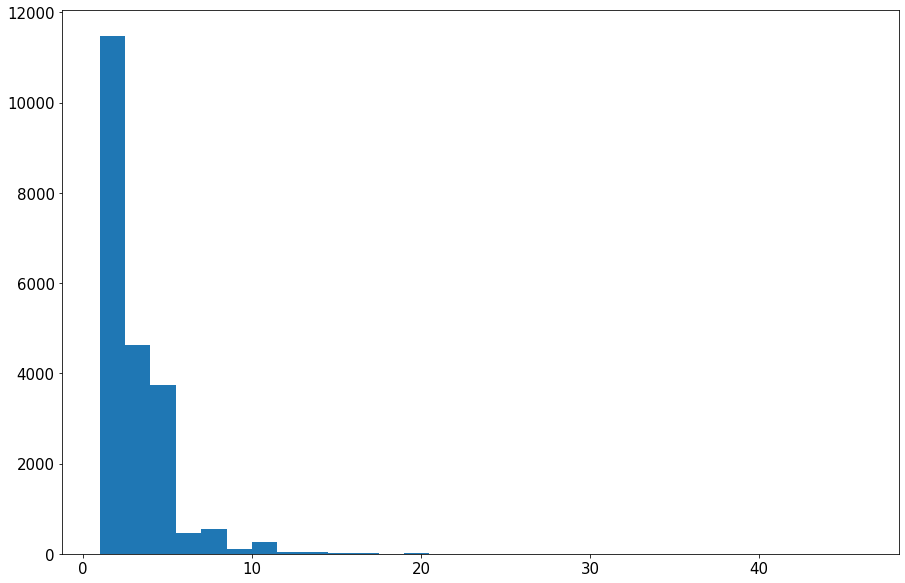

In [4]:
nonzeros = df[df["nonzero_tip"] == 1]
plt.hist(nonzeros["tip"], bins = 30)
plt.show()

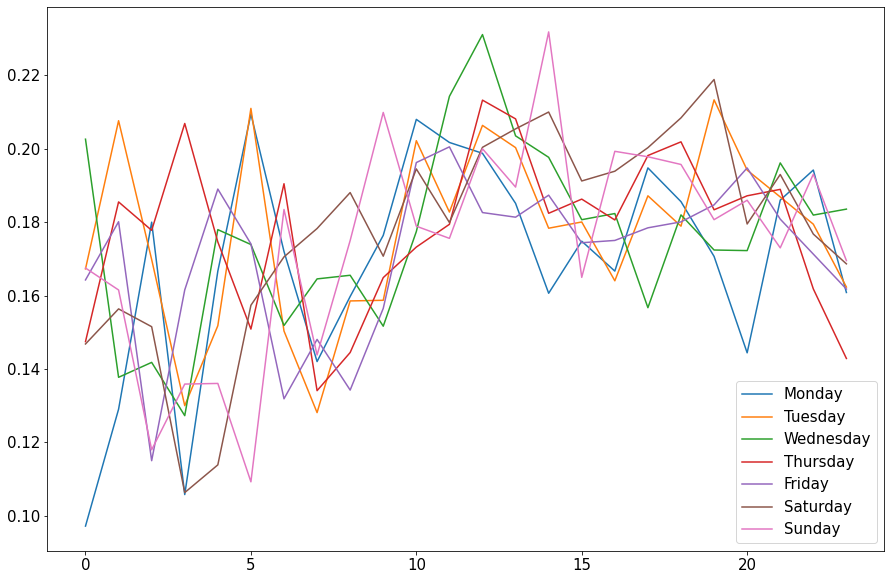

In [5]:
df["day_of_week"] = pd.Categorical(
    df["day_of_week"],
    categories=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    ordered=True,
)
grouped_data = (
    df.groupby(["day_of_week", "hour"]).agg({"nonzero_tip": "sum"}).reset_index()
)
grouped_data2 = (
    df.groupby(["day_of_week", "hour"]).agg({"nonzero_tip": "count"}).reset_index()
)
final = pd.merge(grouped_data, grouped_data2, on=["day_of_week", "hour"], how="inner")
final["tipped_rides"] = final["nonzero_tip_x"] / final["nonzero_tip_y"]
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for i in days:
    temp = final[final["day_of_week"] == i]
    plt.plot(temp["hour"], temp["tipped_rides"], label = i)
plt.legend()
plt.show()

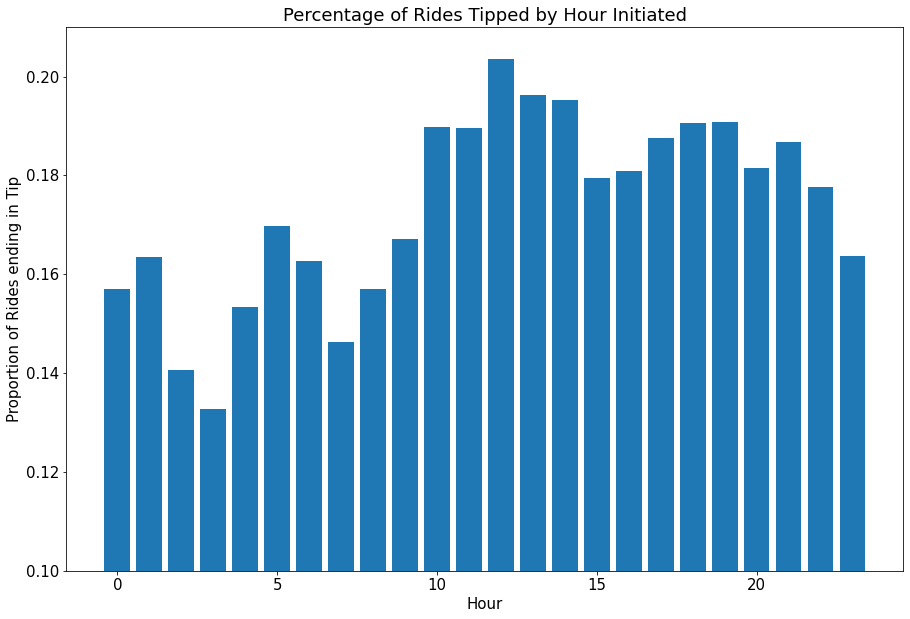

In [6]:
grouped_data = (
    df.groupby(["hour"]).agg({"nonzero_tip": "sum"}).reset_index()
)
grouped_data2 = (
    df.groupby(["hour"]).agg({"nonzero_tip": "count"}).reset_index()
)
final = pd.merge(grouped_data, grouped_data2, on=["hour"], how="inner")
final["tipped_rides"] = final["nonzero_tip_x"] / final["nonzero_tip_y"]
plt.bar(final["hour"], final["tipped_rides"])
plt.title("Percentage of Rides Tipped by Hour Initiated")
plt.ylim([0.10,0.21])
plt.xlabel("Hour")
plt.ylabel("Proportion of Rides ending in Tip")
plt.show()

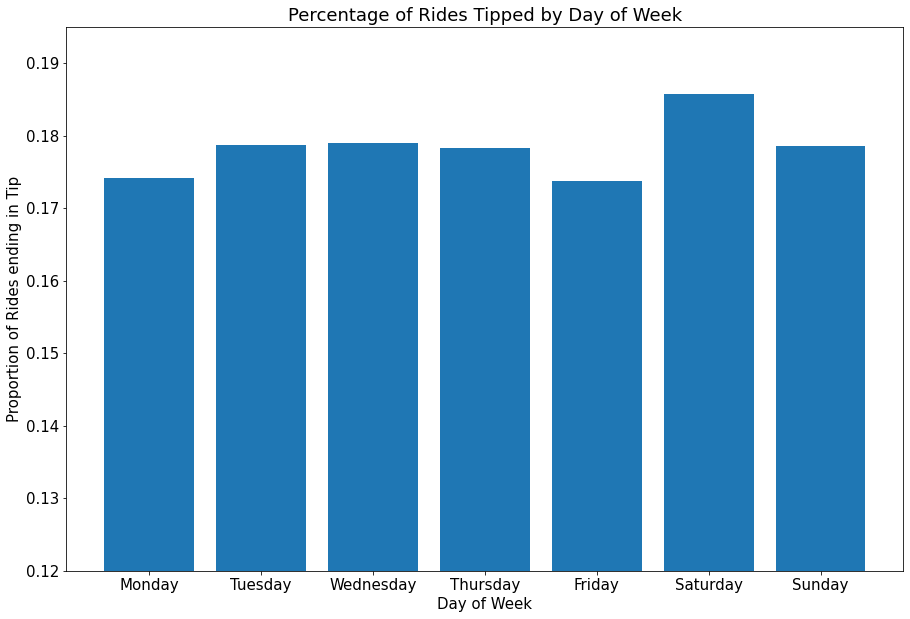

In [7]:
grouped_data = (
    df.groupby(["day_of_week"]).agg({"nonzero_tip": "sum"}).reset_index()
)
grouped_data2 = (
    df.groupby(["day_of_week"]).agg({"nonzero_tip": "count"}).reset_index()
)
final = pd.merge(grouped_data, grouped_data2, on=["day_of_week"], how="inner")
final["tipped_rides"] = final["nonzero_tip_x"] / final["nonzero_tip_y"]
plt.bar(final["day_of_week"], final["tipped_rides"])
plt.title("Percentage of Rides Tipped by Day of Week")
plt.xlabel("Day of Week")
plt.ylim([0.12, 0.195])
plt.ylabel("Proportion of Rides ending in Tip")
plt.show()

Text(0.5, 1.0, 'Trip Length in Seconds by Tip Presence')

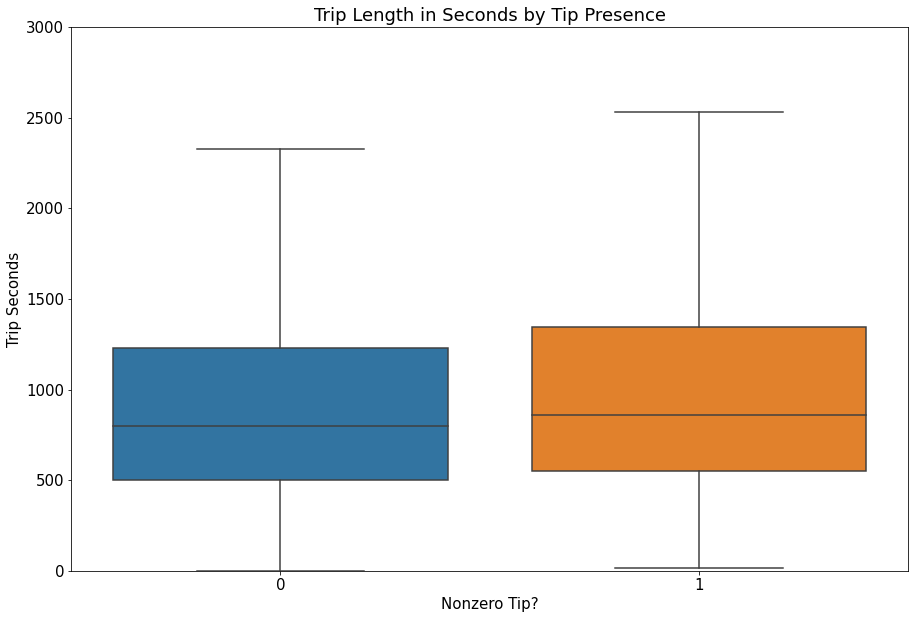

In [8]:
sns.boxplot(y="trip_seconds", x="nonzero_tip", data=df, fliersize = 0)
plt.ylim([0,3000])
plt.xlabel("Nonzero Tip?")
plt.ylabel("Trip Seconds")
plt.title("Trip Length in Seconds by Tip Presence")

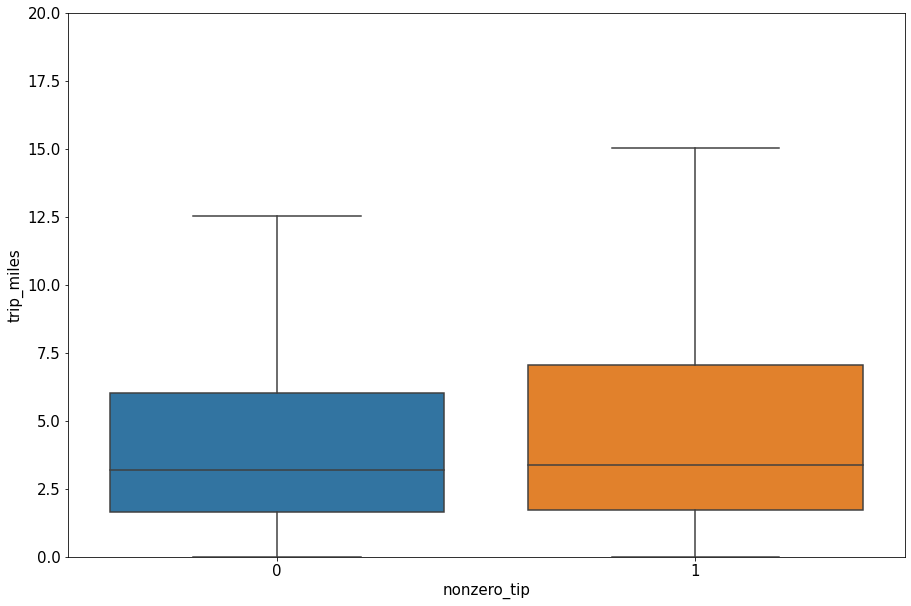

In [9]:
sns.boxplot(y="trip_miles", x="nonzero_tip", data=df, fliersize = 0)
plt.ylim([0,20])
plt.show()

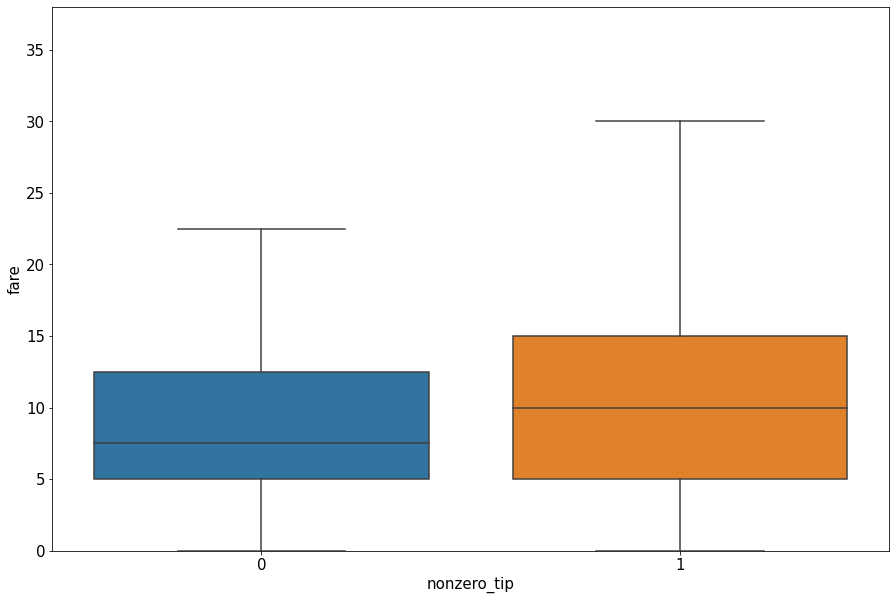

In [10]:
sns.boxplot(y="fare", x="nonzero_tip", data=df, fliersize = 0)
plt.ylim([0,38])
plt.show()

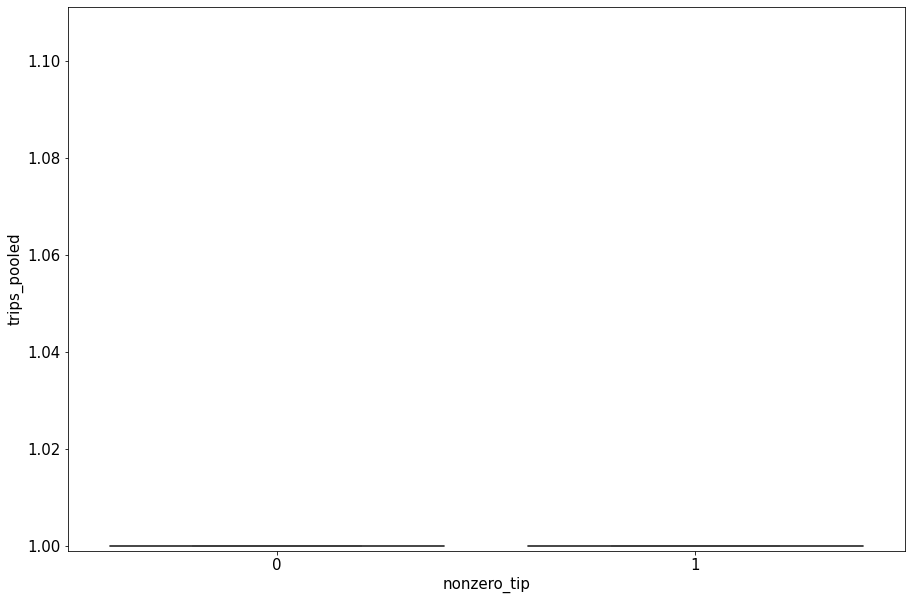

In [11]:
sns.boxplot(y="trips_pooled", x="nonzero_tip", data=df, fliersize = 0)
plt.ylim([0.999, 1.1111])
plt.show()

In [12]:
ca = gpd.read_file("../10_original_data/community_areas.geojson")

In [13]:
grouped_data = (
    df.groupby(["pickup_community_name"])
    .agg({"nonzero_tip": "sum"})
    .reset_index()
)
grouped_data2 = (
    df.groupby(["pickup_community_name"])
    .agg({"nonzero_tip": "count"})
    .reset_index()
)
final = pd.merge(grouped_data, grouped_data2, on=["pickup_community_name"], how="inner")
final["tipped_rides"] = final["nonzero_tip_x"] / final["nonzero_tip_y"]

In [14]:
ca = ca[["community", "geometry"]].rename({"community":"pickup_community_name"}, axis = 1)

In [15]:
test = ca.merge(final, on = "pickup_community_name", how = "inner", validate = "1:1")

In [16]:
ca.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

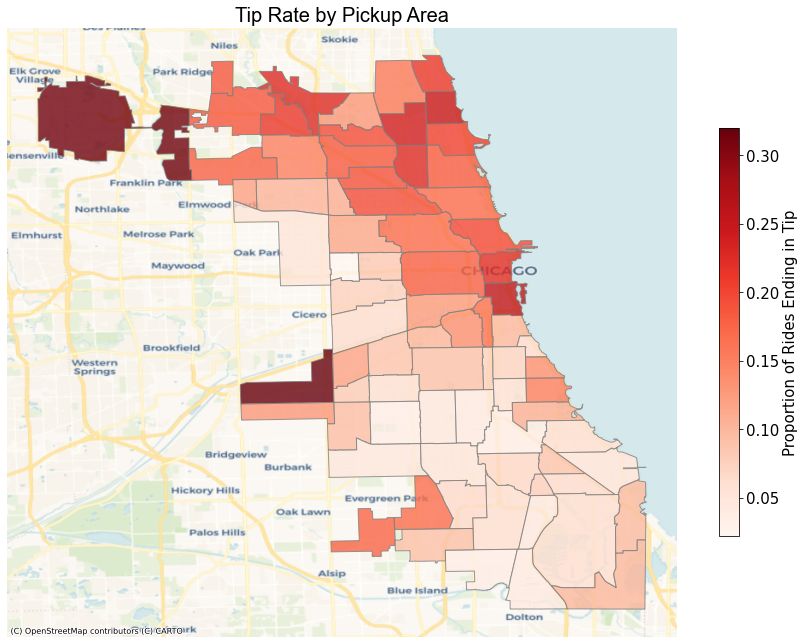

In [21]:
import contextily as cx
test = test.set_crs(epsg=4326)
csfont = {"fontname": "Arial"}
ax = test.plot(
    figsize=(15, 15),
    column="tipped_rides",
    cmap="Reds",
    legend=True,
    legend_kwds={"shrink": 0.5, "label": "Proportion of Rides Ending in Tip"},
    alpha=0.8,
    edgecolor="#808080",
)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.CartoDB.Voyager)
ax.set_axis_off()
ax.set_title(f"Tip Rate by Pickup Area", fontsize=20, **csfont)
plt.show()
